7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1: Data Loss = 11078.373046875, Physics Loss = 10593.3427734375
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 2: Data Loss = 10014.95703125, Physics Loss = 9198.677734375
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 3: Data Loss = 9101.99609375, Physics Loss = 7970.47314453125
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 4: Data Loss = 8245.564453125, Physics Loss = 6783.89013671875
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 5: Data Loss = 7390.36328125, Physics Loss = 5550.1611328125
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 6: Data Loss = 6580.0771484375, Physics Loss = 4305.8037109375
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 7: Data Loss = 5878.328125, Physics Loss = 3108.46630859375
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 8: Data Loss = 5372.48583984375, Physics Loss = 2041.575927734375
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 9: Data Loss = 5170.693359375, Physics Loss = 1214.354736328125
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Ep

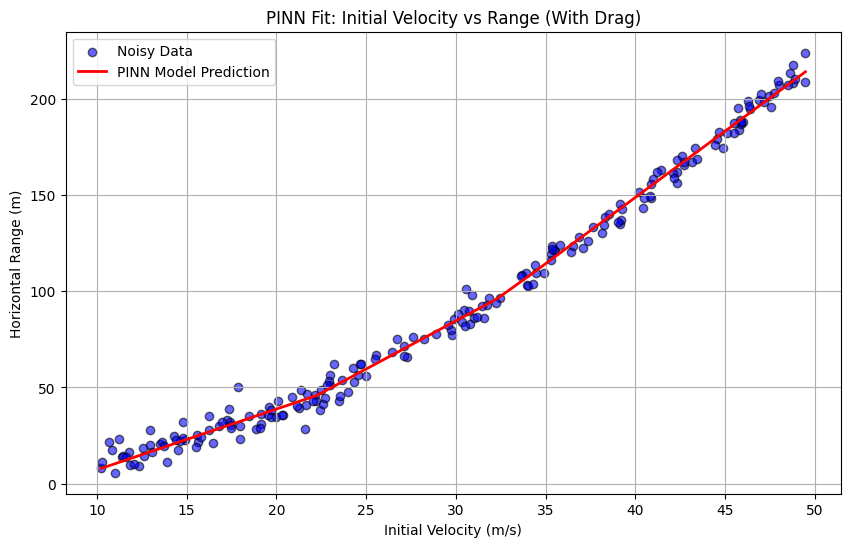

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras
import tensorflow as tf

# Generate data for a thrown ball depending on launch speed, considering drag in the calculation.
np.random.seed(42)

# Number of samples to simulate
num_samples = 200

# Generate random data for initial velocity (m/s).
initial_velocity = np.random.uniform(10, 50, num_samples).astype(np.float32)  # Initial velocity between 10 m/s and 50 m/s.

# Fixed parameters for the calculation
g = tf.constant(9.81, dtype=tf.float32)  # Gravity (m/s^2)
theta = tf.constant(np.radians(45), dtype=tf.float32)  # Fixed launch angle of 45 degrees, converted to radians.
C_d = tf.constant(0.47, dtype=tf.float32)  # Drag coefficient for a sphere.
rho = tf.constant(1.225, dtype=tf.float32)  # Air density at sea level (kg/m^3).
A = tf.constant(0.01, dtype=tf.float32)  # Cross-sectional area of the projectile (m^2).
m = tf.constant(0.1, dtype=tf.float32)  # Mass of the projectile (kg).

# Calculate the true range using the provided formula: d = (v^2 * sin(2 * theta)) / (g + (C_d * rho * A * v) / (2 * m))
drag_term = (C_d * rho * A * initial_velocity) / (2 * m)
true_range_with_drag = (initial_velocity**2 * np.sin(2 * theta)) / (g + drag_term)

# Add some light noise to the range values to simulate measurement variations.
noisy_range = true_range_with_drag + np.random.normal(0, 5, num_samples).astype(np.float32)

# Prepare the input and output data for training the neural network
X_velocity = tf.convert_to_tensor(initial_velocity.reshape(-1, 1), dtype=tf.float32)  # Input: Initial velocity as TensorFlow tensor
y_range_noisy = tf.convert_to_tensor(noisy_range, dtype=tf.float32)  # Output: Noisy range values as TensorFlow tensor

# Define a custom loss function that combines data loss and physics-based loss.
def pinn_loss(y_true, y_pred):
    # Ensure y_true and y_pred are in float32
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Extract the corresponding batch of X values
    X_batch = X_velocity[:tf.shape(y_true)[0]]  # Adjust to the current batch size

    # Calculate the drag term for the current batch
    drag_term_batch = 0*(C_d * rho * A * X_batch) / (2 * m)
    
    # Physics formula for range with drag in the batch
    physics_based_range = (X_batch ** 2 * tf.sin(2 * theta)) / (g + drag_term_batch)
    
    # MSE for the data (difference between predictions and true values)
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Physics-based MSE: enforce the relationship from the motion equation with drag.
    physics_loss = tf.reduce_mean(
        tf.square(y_pred - physics_based_range)
    )
    
    # Combine losses with a weight for the physics loss.
    lambda_weight = 0.1  # You can adjust this to balance the two terms.
    total_loss = data_loss + lambda_weight * physics_loss
    return total_loss

# Define a Keras Sequential model.
pinn_model = Sequential([
    Dense(64, activation='relu', input_dim=1),  # Input layer with 64 neurons
    Dense(64, activation='relu'),               # Hidden layer with 64 neurons
    Dense(1)                                    # Output layer for predicting range
])

# Compile the model using the custom loss function.
pinn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=pinn_loss)

# Train the model on the velocity data and the noisy range.
class LossMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_velocity)
        # Calculate physics-based range on the entire dataset
        drag_term_all = (C_d * rho * A * X_velocity) / (2 * m)
        physics_based_range = (X_velocity ** 2 * tf.sin(2 * theta)) / (g + drag_term_all)
        
        # Compute separate data and physics losses
        data_loss = tf.reduce_mean(tf.square(y_range_noisy - y_pred))
        physics_loss = tf.reduce_mean(tf.square(y_pred - physics_based_range))
        
        print(f"Epoch {epoch + 1}: Data Loss = {data_loss.numpy()}, Physics Loss = {physics_loss.numpy()}")

# Add this callback to the model fitting process
history = pinn_model.fit(X_velocity, y_range_noisy, epochs=400, batch_size=200, shuffle=False, verbose=0, callbacks=[LossMonitor()])


# Make predictions using the trained PINN model.
y_pred_pinn = pinn_model.predict(X_velocity).flatten()

# Sort the input velocities and corresponding predictions for a smooth plot.
sorted_indices = np.argsort(initial_velocity)
sorted_velocity = initial_velocity[sorted_indices]
sorted_y_pred_pinn = y_pred_pinn[sorted_indices]

# Plot the original data and the PINN model's predictions.
plt.figure(figsize=(10, 6))
plt.scatter(X_velocity.numpy(), y_range_noisy.numpy(), color='blue', alpha=0.6, edgecolors='black', label='Noisy Data')
plt.plot(sorted_velocity, sorted_y_pred_pinn, color='red', linewidth=2, label='PINN Model Prediction')
plt.xlabel('Initial Velocity (m/s)')
plt.ylabel('Horizontal Range (m)')
plt.title('PINN Fit: Initial Velocity vs Range (With Drag)')
plt.grid(True)
plt.legend()
plt.show()